In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_602_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1428_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1282_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_93_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_59_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1992_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1461_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_101_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_379_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_598_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1303_.jpg
/kaggle/input/semantic-segmen

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *


2025-09-01 12:19:09.722708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756729150.076444      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756729150.173171      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
color_map = {
    (0, 0, 0): 0,        # BW
    (0, 0, 255): 1,      # HD 
    (0, 255, 0): 2,      # PF 
    (255, 255, 0): 3,    # WR 
    (0, 0, 128): 4,      # RO 
    (255, 0, 255): 5,    # RI 
    (0, 255, 255): 6,    # FV 
    (255, 255, 255): 7   # SR
}

In [4]:
index_to_color = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (0, 255, 0),
    3: (255, 255, 0),
    4: (0, 0, 128),
    5: (255, 0, 255),
    6: (0, 255, 255),
    7: (255, 255, 255)
}

In [5]:
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for filename in os.listdir(os.path.join(image_dir, "images")):
        if filename.endswith(".jpg"):
            base_name = os.path.splitext(filename)[0]
            img_path = os.path.join(image_dir, "images", filename)
            mask_path = os.path.join(mask_dir, "masks", base_name + ".bmp")
            
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
    
    return image_paths, mask_paths


def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=25,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.5
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.3,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.2
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.3
        )
    ], additional_targets={'mask': 'image'})

def data_generator(image_paths, mask_paths, batch_size=8, image_size=(256, 256)):
    aug = get_augmentation()
    while True:
        indices = np.random.permutation(len(image_paths))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_masks = []
            
            for j in batch_indices:
                img = cv2.imread(image_paths[j])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR转RGB
                img = cv2.resize(img, image_size)
                img = img.astype(np.float32) / 255.0
                
                mask = cv2.imread(mask_paths[j])
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # BGR转RGB
                mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

                augmented = aug(image=img, mask=mask)
                img_aug = augmented['image']
                mask_aug = augmented['mask']
                
                class_mask = np.zeros(mask_aug.shape[:2], dtype=np.uint8)
                for color, idx in color_map.items():
                    class_mask[np.all(mask_aug == color, axis=-1)] = idx
                
                batch_images.append(img_aug)
                batch_masks.append(class_mask)
            
            yield np.array(batch_images), np.array(batch_masks)


In [6]:
def unet_model(input_size=(256, 256, 3), num_classes=8):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(512, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c4)
    
    u5 = UpSampling2D((2,2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c5)
    
    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c6)
    
    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c7)
    
    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c7)
    
    model = Model(inputs=inputs, outputs=outputs)
 
   # model.compile(optimizer=Adam(learning_rate=1e-4),
    #         loss=sparse_combined_loss,
     #        metrics=['accuracy'])

    return model


In [7]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 5
EPOCHS = 75


train_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"
train_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"
test_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"
test_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"

train_image_paths, train_mask_paths = load_data(train_image_dir, train_mask_dir)
test_image_paths, test_mask_paths = load_data(test_image_dir, test_mask_dir)

train_img, val_img, train_msk, val_msk = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42)


In [8]:
def sparse_combined_loss(y_true, y_pred, alpha=0.5, num_classes=8):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_oh = tf.nn.softmax(y_pred)
    
    intersection = tf.reduce_sum(y_true_oh * y_pred_oh, axis=[1,2])
    union = tf.reduce_sum(y_true_oh + y_pred_oh, axis=[1,2])
    dice_loss = 1 - tf.reduce_mean((2. * intersection + 1e-7)/(union + 1e-7))
    
    gamma = 2.0
    focal_loss = tf.reduce_mean(-(1-y_pred_oh)**gamma * tf.math.log(y_pred_oh + 1e-7))
    
    return alpha*ce_loss + (0.5-alpha)*dice_loss + 0.2*focal_loss

In [9]:
def calculate_metrics(true_mask, pred_mask, num_classes):

    dice = np.zeros(num_classes)
    iou = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for cls in range(num_classes):
        true_cls = (true_mask == cls)
        pred_cls = (pred_mask == cls)
        
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        true_sum = true_cls.sum()
        pred_sum = pred_cls.sum()
        
        dice[cls] = (2. * intersection) / (true_sum + pred_sum + 1e-7)
        
        # IoU
        iou[cls] = intersection / (union + 1e-7)
        
        # F1
        precision = intersection / (pred_sum + 1e-7)
        recall = intersection / (true_sum + 1e-7)
        f1[cls] = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return dice, iou, f1


In [10]:
def visualize_results(image_path, mask_path, model, size=(256,256)):
    # 1.（BGR→RGB）
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    orig_size = img.shape[:2]
    img = cv2.resize(img, size)
    img_input = img.astype(np.float32)/255.0
    img_input = np.expand_dims(img_input, axis=0)
    
    # 2. predict
    pred = model.predict(img_input)[0]
    pred_mask = np.argmax(pred, axis=-1)
    
    # 3. mask（BGR→RGB）
    true_mask = cv2.imread(mask_path)
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)  
    true_mask = cv2.resize(true_mask, size, interpolation=cv2.INTER_NEAREST)
    
    true_class = np.zeros(true_mask.shape[:2], dtype=np.uint8)
    for color, idx in color_map.items(): 
        true_class[np.all(true_mask == color, axis=-1)] = idx
    
    
    pred_color = np.zeros((*size, 3), dtype=np.uint8)
    true_color = np.zeros((*size, 3), dtype=np.uint8)
    
    for idx, color in index_to_color.items():  
        pred_color[pred_mask == idx] = color
        true_color[true_class == idx] = color
    
   
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img) 
    plt.title("Original Image")
    
    plt.subplot(1,3,2)
    plt.imshow(true_color)
    plt.title("True Mask")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.show()

In [11]:
train_gen = data_generator(train_img, train_msk, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(val_img, val_msk, BATCH_SIZE, IMAGE_SIZE)


model = unet_model(input_size=IMAGE_SIZE + (3,))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=sparse_combined_loss,
             metrics=['accuracy']
             )
model.summary()

I0000 00:00:1756729166.273902      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756729166.274703      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,368 (29.69 MB)

 Trainable params: 7,783,368 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_img)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_img)//BATCH_SIZE,
    epochs=EPOCHS
)

val_dice = []
val_iou = []
val_f1 = []

for i in range(len(val_img)//BATCH_SIZE):
    x_val, y_val = next(val_gen)
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    for j in range(len(y_val)):
        true_mask = y_val[j]
        pred_mask = y_pred[j]
        dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
        val_dice.append(dice)
        val_iou.append(iou)
        val_f1.append(f1)

avg_val_dice = np.mean(val_dice, axis=0)
avg_val_iou = np.mean(val_iou, axis=0)
avg_val_f1 = np.mean(val_f1, axis=0)

class_names = list(index_to_color.keys())
for cls, name in enumerate(class_names):
    print(f"Class {name}:")
    print(f"  Dice: {avg_val_dice[cls]:.4f}")
    print(f"  IoU: {avg_val_iou[cls]:.4f}")
    print(f"  F1: {avg_val_f1[cls]:.4f}")
    print()

mIoU = np.mean(avg_val_iou)
avg_dice = np.mean(avg_val_dice)
print(f"mIoU: {mIoU:.4f}")
print(f"Average Dice: {avg_dice:.4f}")


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch 1/75


I0000 00:00:1756729175.842527     104 service.cc:148] XLA service 0x799f60014170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756729175.844086     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756729175.844106     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1756729176.280060     104 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1756729176.647880     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-01 12:19:40.563840: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[5,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf0

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5229 - loss: 1.0608

W0000 00:00:1756729280.448141     104 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


244/244 ━━━━━━━━━━━━━━━━━━━━ 138s 416ms/step - accuracy: 0.5231 - loss: 1.0606 - val_accuracy: 0.5646 - val_loss: 0.9560
Epoch 2/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.6066 - loss: 0.9322 - val_accuracy: 0.5886 - val_loss: 0.9309
Epoch 3/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 294ms/step - accuracy: 0.5932 - loss: 0.9375 - val_accuracy: 0.5778 - val_loss: 0.9290
Epoch 4/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 71s 293ms/step - accuracy: 0.5883 - loss: 0.9334 - val_accuracy: 0.6137 - val_loss: 0.9163
Epoch 5/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 71s 292ms/step - accuracy: 0.5994 - loss: 0.9175 - val_accuracy: 0.6056 - val_loss: 0.8950
Epoch 6/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.6069 - loss: 0.8981 - val_accuracy: 0.6057 - val_loss: 0.8851
Epoch 7/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.6063 - loss: 0.8884 - val_accuracy: 0.6073 - val_loss: 0.9213
Epoch 8/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 71s 292ms/step - accuracy: 0.6130 - loss: 0.8854 - va

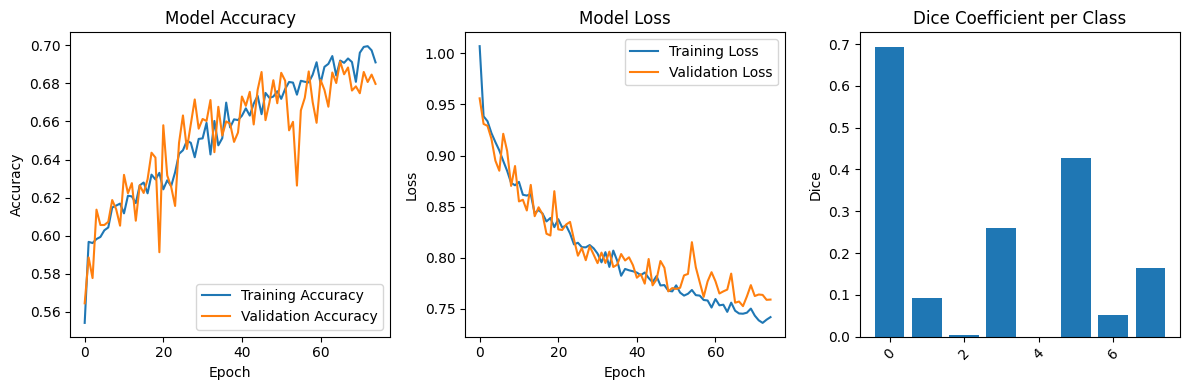

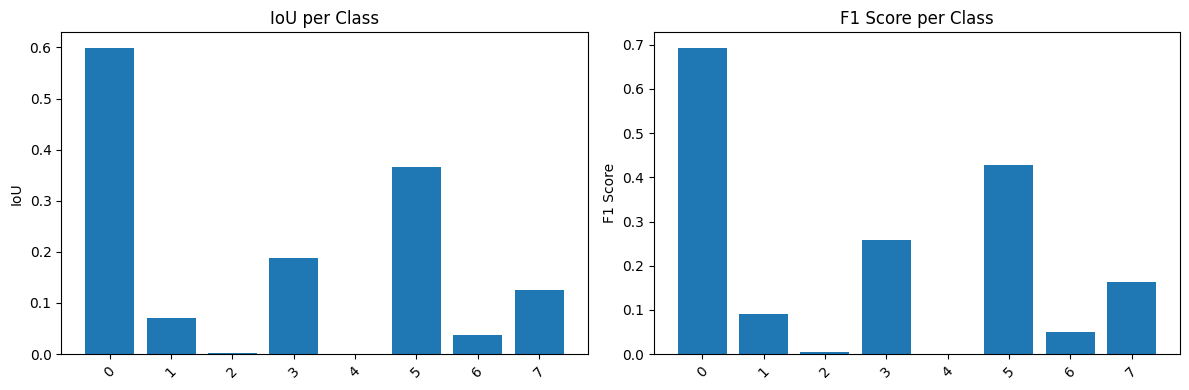

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 3, 3)
plt.bar(class_names, avg_val_dice)
plt.title('Dice Coefficient per Class')
plt.ylabel('Dice')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 4))

# IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, avg_val_iou)
plt.title('IoU per Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)

# F1
plt.subplot(1, 2, 2)
plt.bar(class_names, avg_val_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


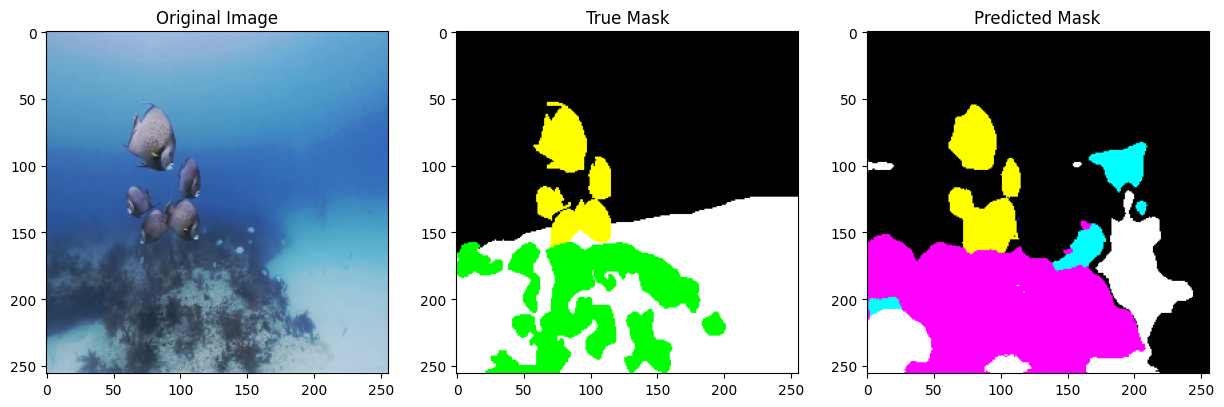

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


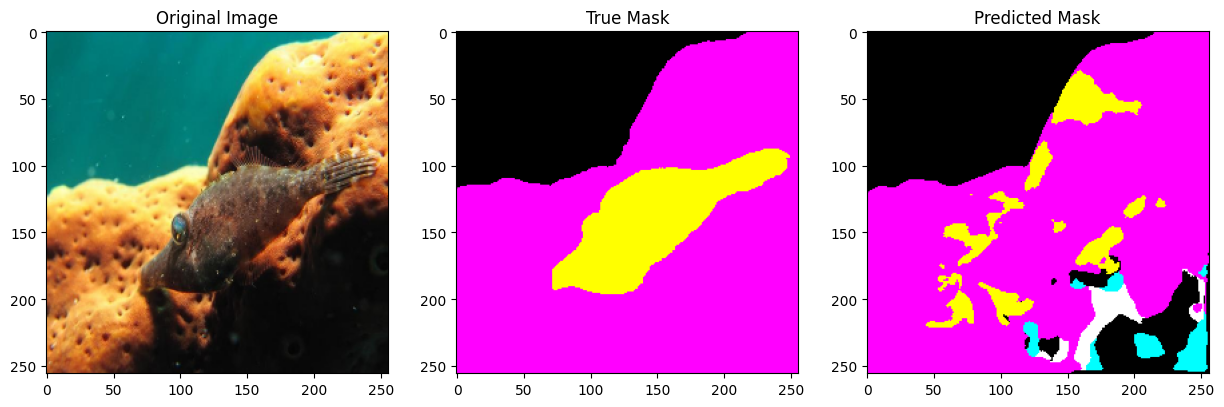

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


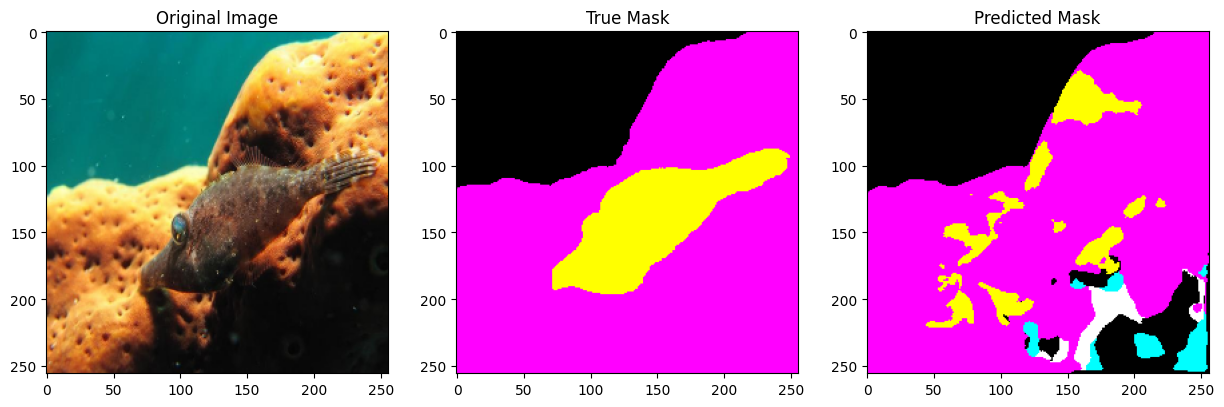

In [14]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model)

UNET + SE

In [15]:
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)
    
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    se = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal')(se)
    
    return Multiply()([input_tensor, se])

In [16]:
def attention_unet_model(input_size=(256, 256, 3), num_classes=8):
    inputs = Input(input_size)
    
    # Block 1
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    s1 = se_block(c1)  
    p1 = MaxPooling2D((2,2))(s1)
    
    # Block 2
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    s2 = se_block(c2) 
    p2 = MaxPooling2D((2,2))(s2)
    
    # Block 3
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    s3 = se_block(c3)  
    p3 = MaxPooling2D((2,2))(s3)

    # Block 4
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    s4 = se_block(c4) 

    # Block 5
    u5 = UpSampling2D((2,2))(s4)
    u5 = concatenate([u5, s3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)
    
    # Block 6
    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, s2]) 
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)
    
    # Block 7
    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, s1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c7)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [17]:
model_se = attention_unet_model(input_size=IMAGE_SIZE + (3,))

model_se.compile(optimizer=Adam(learning_rate=1e-4),
              loss=sparse_combined_loss,
             metrics=['accuracy']
             )
model_se.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_16[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        260 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ conv2d_16[0][0],  │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_18[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 8)   │      1,032 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 128) │      1,152 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 128,  │          0 │ conv2d_18[0][0],  │
│ (Multiply)          │ 128)              │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ multiply_1[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_19[0][0] 

 Total params: 7,827,908 (29.86 MB)

 Trainable params: 7,827,908 (29.86 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model_se.fit(
    train_gen,
    steps_per_epoch=len(train_img)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_img)//BATCH_SIZE,
    epochs=EPOCHS
)

val_dice = []
val_iou = []
val_f1 = []

for i in range(len(val_img)//BATCH_SIZE):
    x_val, y_val = next(val_gen)
    y_pred = model_se.predict(x_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    for j in range(len(y_val)):
        true_mask = y_val[j]
        pred_mask = y_pred[j]
        dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
        val_dice.append(dice)
        val_iou.append(iou)
        val_f1.append(f1)

avg_val_dice = np.mean(val_dice, axis=0)
avg_val_iou = np.mean(val_iou, axis=0)
avg_val_f1 = np.mean(val_f1, axis=0)

class_names = list(index_to_color.keys())
for cls, name in enumerate(class_names):
    print(f"Class {name}:")
    print(f"  Dice: {avg_val_dice[cls]:.4f}")
    print(f"  IoU: {avg_val_iou[cls]:.4f}")
    print(f"  F1: {avg_val_f1[cls]:.4f}")
    print()

mIoU = np.mean(avg_val_iou)
avg_dice = np.mean(avg_val_dice)
print(f"mIoU: {mIoU:.4f}")
print(f"Average Dice: {avg_dice:.4f}")


Epoch 1/75


W0000 00:00:1756734604.809405     104 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4161 - loss: 1.1470

W0000 00:00:1756734677.016580     103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


244/244 ━━━━━━━━━━━━━━━━━━━━ 91s 313ms/step - accuracy: 0.4164 - loss: 1.1466 - val_accuracy: 0.5546 - val_loss: 0.9810
Epoch 2/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 73s 300ms/step - accuracy: 0.5835 - loss: 0.9499 - val_accuracy: 0.5774 - val_loss: 0.9456
Epoch 3/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.5734 - loss: 0.9494 - val_accuracy: 0.5732 - val_loss: 0.9406
Epoch 4/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.5910 - loss: 0.9298 - val_accuracy: 0.5938 - val_loss: 0.9268
Epoch 5/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 297ms/step - accuracy: 0.5840 - loss: 0.9366 - val_accuracy: 0.5796 - val_loss: 0.9158
Epoch 6/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.5934 - loss: 0.9169 - val_accuracy: 0.5930 - val_loss: 0.9063
Epoch 7/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.5909 - loss: 0.9232 - val_accuracy: 0.5951 - val_loss: 0.8947
Epoch 8/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 72s 296ms/step - accuracy: 0.5809 - loss: 0.9167 - val

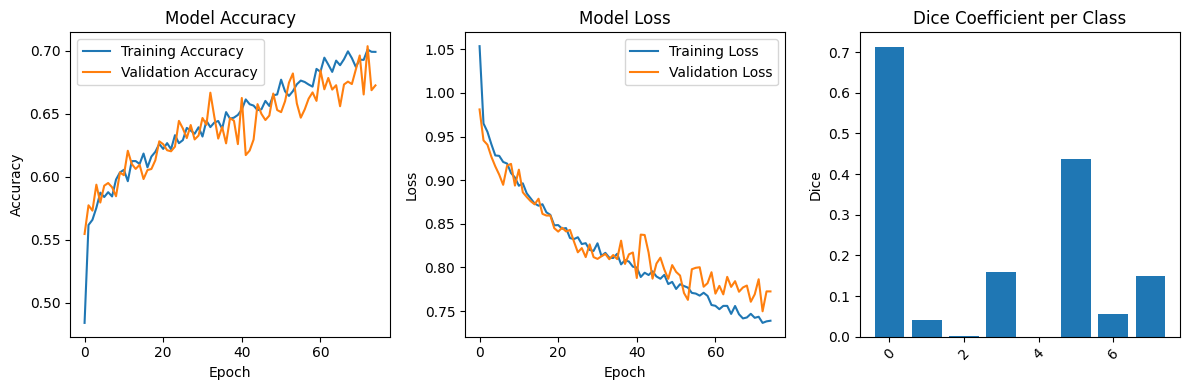

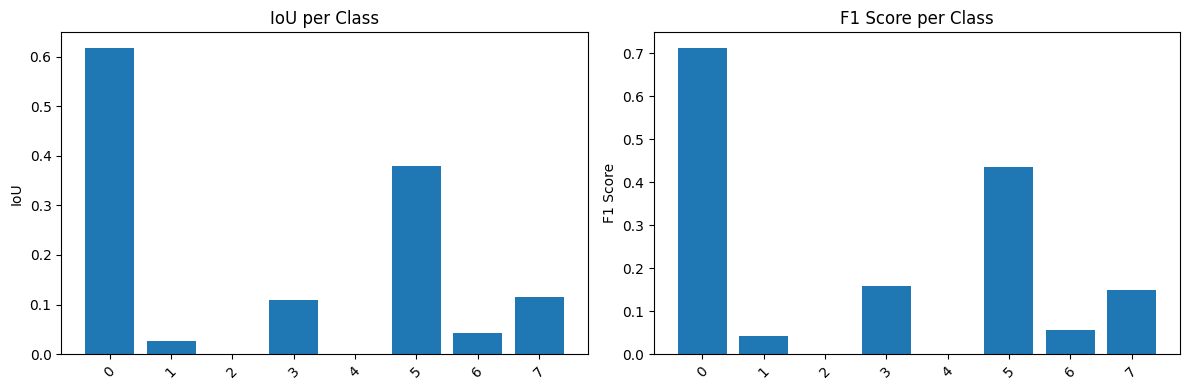

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(class_names, avg_val_dice)
plt.title('Dice Coefficient per Class')
plt.ylabel('Dice')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 4))

# IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, avg_val_iou)
plt.title('IoU per Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)

# F1
plt.subplot(1, 2, 2)
plt.bar(class_names, avg_val_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


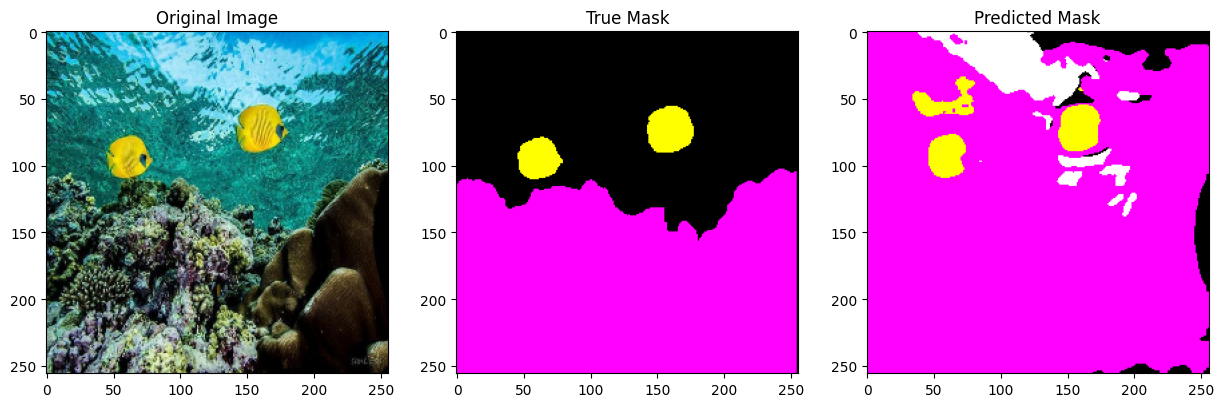

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


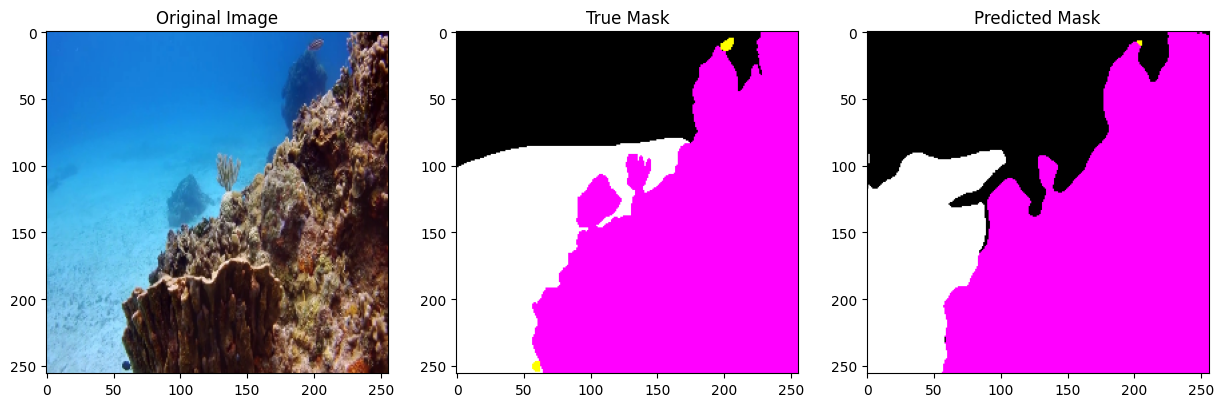

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


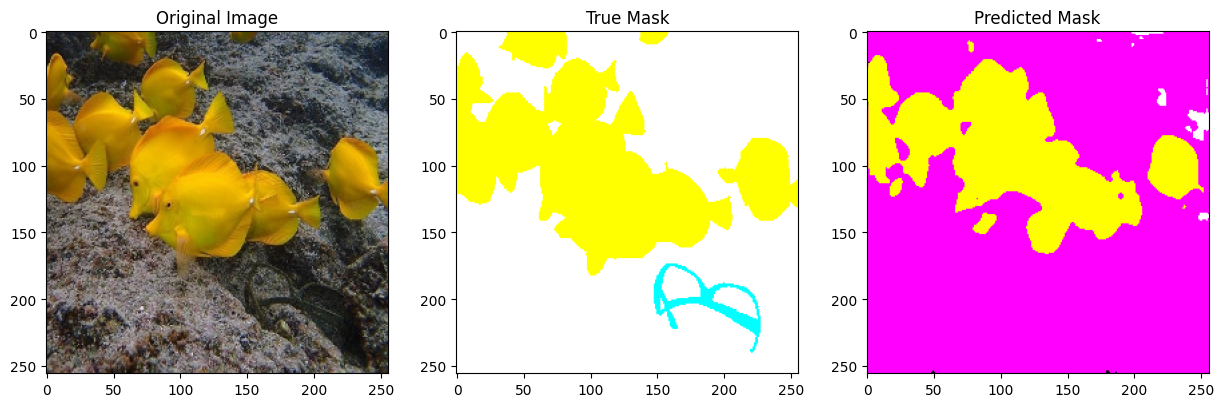

In [20]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model_se)

UNET + CBAM

In [21]:

def channel_attention(input_feature, ratio=8):
    """Channel Attention Module"""
    channel = input_feature.shape[-1]
    
    # Shared MLP
    shared_layer_one = Dense(channel//ratio, activation='relu', use_bias=False)
    shared_layer_two = Dense(channel, use_bias=False)
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1,2], keepdims=True))(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    """Spatial Attention Module"""
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(1, (7,7), strides=1, padding='same', activation='sigmoid')(concat)
    
    return Multiply()([input_feature, cbam_feature])

def cbam_block(input_feature, ratio=8):
    """Complete CBAM block"""
    # Channel attention first
    channel_refined = channel_attention(input_feature, ratio)
    
    # Then spatial attention
    spatial_refined = spatial_attention(channel_refined)
    
    return spatial_refined


In [22]:
def unet_cbam_model(input_size=(256, 256, 3), num_classes=8):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c1)
    cb1 = cbam_block(c1)  # Add CBAM after first conv block
    p1 = MaxPooling2D((2,2))(cb1)
    
    c2 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c2)
    cb2 = cbam_block(c2)  # Add CBAM
    p2 = MaxPooling2D((2,2))(cb2)
    
    c3 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c3)
    cb3 = cbam_block(c3)  # Add CBAM
    p3 = MaxPooling2D((2,2))(cb3)
    
    c4 = Conv2D(512, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c4)
    cb4 = cbam_block(c4)  # Add CBAM
    
    u5 = UpSampling2D((2,2))(cb4)
    u5 = concatenate([u5, cb3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c5)
    cb5 = cbam_block(c5)  # Add CBAM
    
    u6 = UpSampling2D((2,2))(cb5)
    u6 = concatenate([u6, cb2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c6)
    cb6 = cbam_block(c6)  # Add CBAM
    
    u7 = UpSampling2D((2,2))(cb6)
    u7 = concatenate([u7, cb1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer = 'he_normal')(c7)
    cb7 = cbam_block(c7)  # Add CBAM
    
    outputs = Conv2D(num_classes, (1,1), activation='softmax')(cb7)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


In [23]:

model_cbam = unet_cbam_model(input_size=IMAGE_SIZE + (3,))

model_cbam.compile(optimizer=Adam(learning_rate=1e-4),
              loss=sparse_combined_loss,
             metrics=['accuracy']
             )
model_cbam.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_31[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 64)  │          0 │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 8)   │        512 │ reshape_4[0][0],  │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1, 64)  │        512 │ dense_8[0][0],    │
│                     │                   │            │ dense_8[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 64)  │          0 │ dense_9[0][0],    │
│                     │                   │            │ dense_9[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 256, 256,  │          0 │ conv2d_31[0][0],  │
│ (Multiply)          │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ multiply_4[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256,  │          0 │ multiply_4[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256, 256,  │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │ 2)                │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │         99 │ concatenate_6[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 256, 256,  │          0 │ multiply_4[0][0], │
│ (Multiply)          │ 64)               │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ multiply_5[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,892,605 (30.11 MB)

 Trainable params: 7,892,605 (30.11 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:

history = model_cbam.fit(
    train_gen,
    steps_per_epoch=len(train_img)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_img)//BATCH_SIZE,
    epochs=EPOCHS
)

val_dice = []
val_iou = []
val_f1 = []

for i in range(len(val_img)//BATCH_SIZE):
    x_val, y_val = next(val_gen)
    y_pred = model_cbam.predict(x_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    for j in range(len(y_val)):
        true_mask = y_val[j]
        pred_mask = y_pred[j]
        dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
        val_dice.append(dice)
        val_iou.append(iou)
        val_f1.append(f1)

avg_val_dice = np.mean(val_dice, axis=0)
avg_val_iou = np.mean(val_iou, axis=0)
avg_val_f1 = np.mean(val_f1, axis=0)

class_names = list(index_to_color.keys())
for cls, name in enumerate(class_names):
    print(f"Class {name}:")
    print(f"  Dice: {avg_val_dice[cls]:.4f}")
    print(f"  IoU: {avg_val_iou[cls]:.4f}")
    print(f"  F1: {avg_val_f1[cls]:.4f}")
    print()

mIoU = np.mean(avg_val_iou)
avg_dice = np.mean(avg_val_dice)
print(f"mIoU: {mIoU:.4f}")
print(f"Average Dice: {avg_dice:.4f}")



Epoch 1/75


W0000 00:00:1756740058.027913     103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4836 - loss: 1.2021

W0000 00:00:1756740138.970019     103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


244/244 ━━━━━━━━━━━━━━━━━━━━ 106s 338ms/step - accuracy: 0.4837 - loss: 1.2017 - val_accuracy: 0.5462 - val_loss: 1.0035
Epoch 2/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 321ms/step - accuracy: 0.5579 - loss: 0.9770 - val_accuracy: 0.5854 - val_loss: 0.9343
Epoch 3/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - accuracy: 0.5929 - loss: 0.9246 - val_accuracy: 0.6098 - val_loss: 0.8831
Epoch 4/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 318ms/step - accuracy: 0.6008 - loss: 0.9136 - val_accuracy: 0.5959 - val_loss: 0.9037
Epoch 5/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 318ms/step - accuracy: 0.6066 - loss: 0.8966 - val_accuracy: 0.6232 - val_loss: 0.8823
Epoch 6/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 318ms/step - accuracy: 0.6132 - loss: 0.8826 - val_accuracy: 0.5957 - val_loss: 0.8990
Epoch 7/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - accuracy: 0.5990 - loss: 0.8947 - val_accuracy: 0.6227 - val_loss: 0.8763
Epoch 8/75
244/244 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - accuracy: 0.6158 - loss: 0.8725 - va

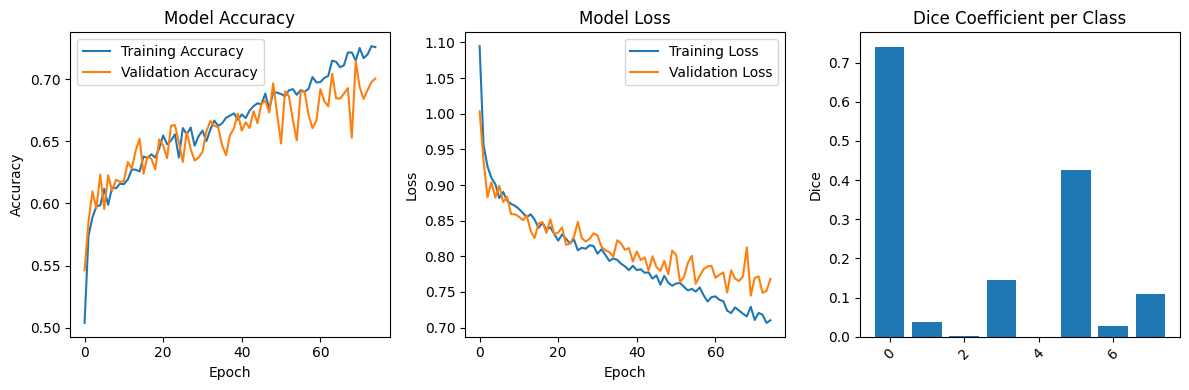

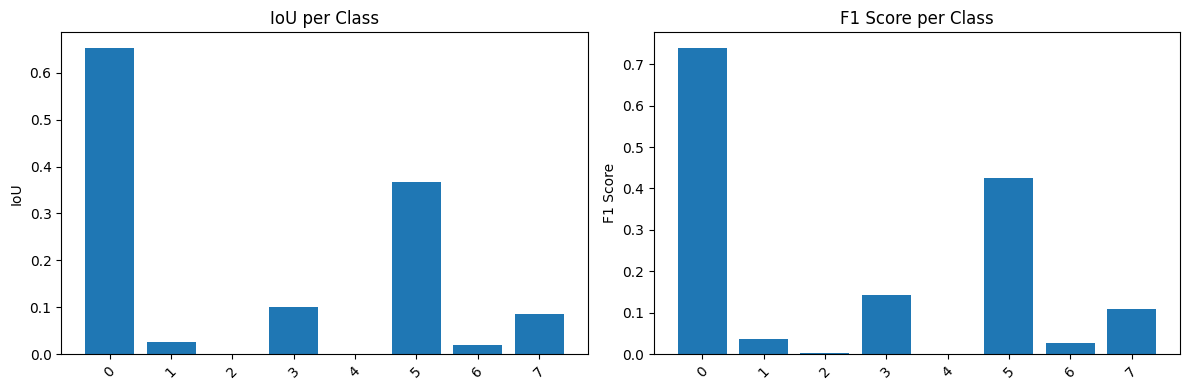

In [25]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(class_names, avg_val_dice)
plt.title('Dice Coefficient per Class')
plt.ylabel('Dice')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 4))

# IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, avg_val_iou)
plt.title('IoU per Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)

# F1
plt.subplot(1, 2, 2)
plt.bar(class_names, avg_val_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


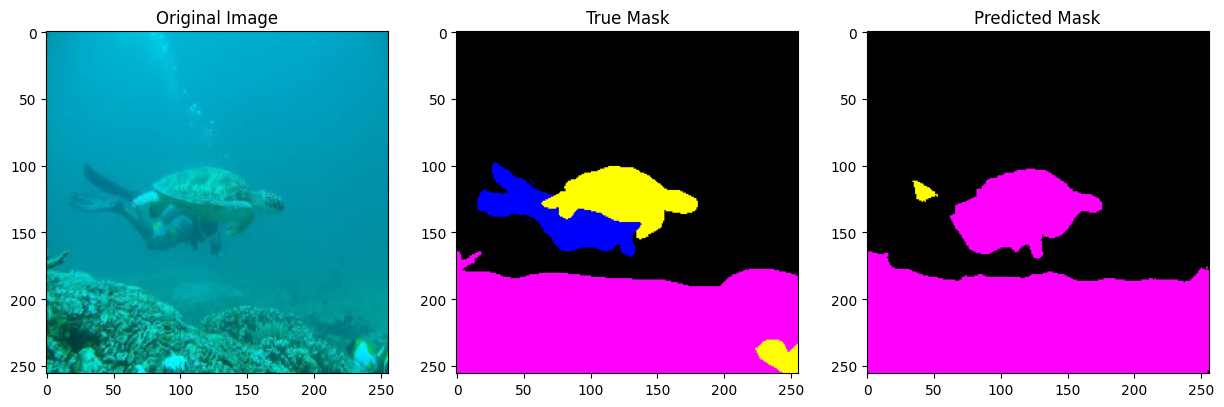

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


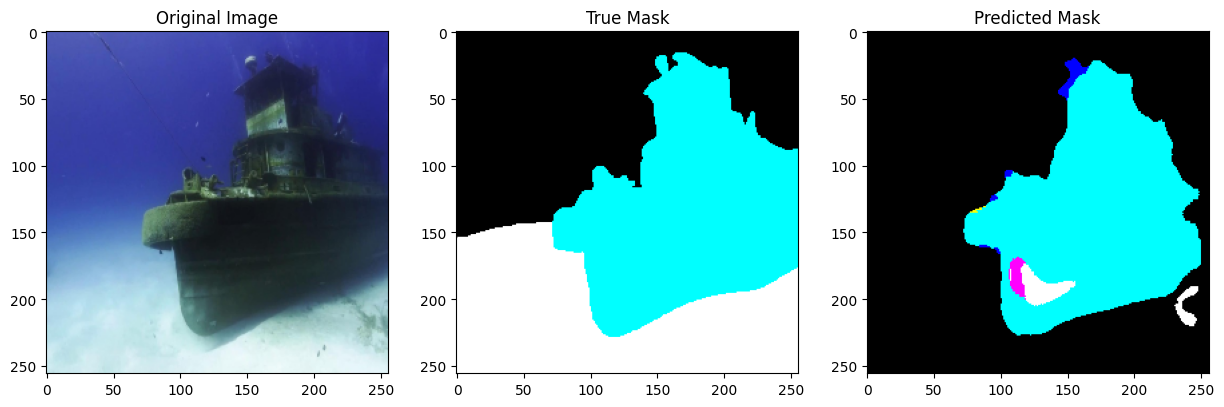

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


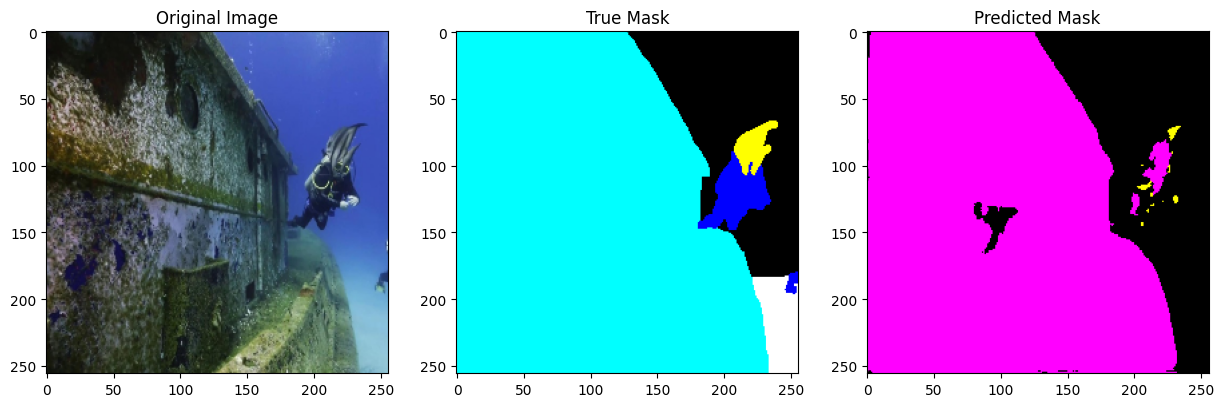

In [26]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model_cbam)